In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE, SelectFromModel
from collections import Counter
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed
from boruta import BorutaPy


Read and Encode test data

In [40]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
#df = df.sample(n=2000, replace=False, random_state=42)

model = SentenceTransformer("all-MiniLM-L6-v2")  
text_embeddings = model.encode(df["text"].astype(str).tolist(), convert_to_numpy=True)
df["text"] = text_embeddings.mean(axis=1)  
screen_name_embeddings = model.encode(df["screen_name"].astype(str).tolist(), convert_to_numpy=True)
df["screen_name"] = screen_name_embeddings.mean(axis=1)  

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [52]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)


GBC using all features of the dataset

In [54]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

preds = gbc.predict(X_test)
probs = gbc.predict_proba(X_test)[:, 1]  

f1_score_all = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
auc_score_all = round(roc_auc_score(y_test, probs), 6)

# Print results
print(f"F1 Score: {f1_score_all}")
print(f"AUC Score: {auc_score_all}")


F1 Score: 0.946735
AUC Score: 0.64925


Variance Treshold Method

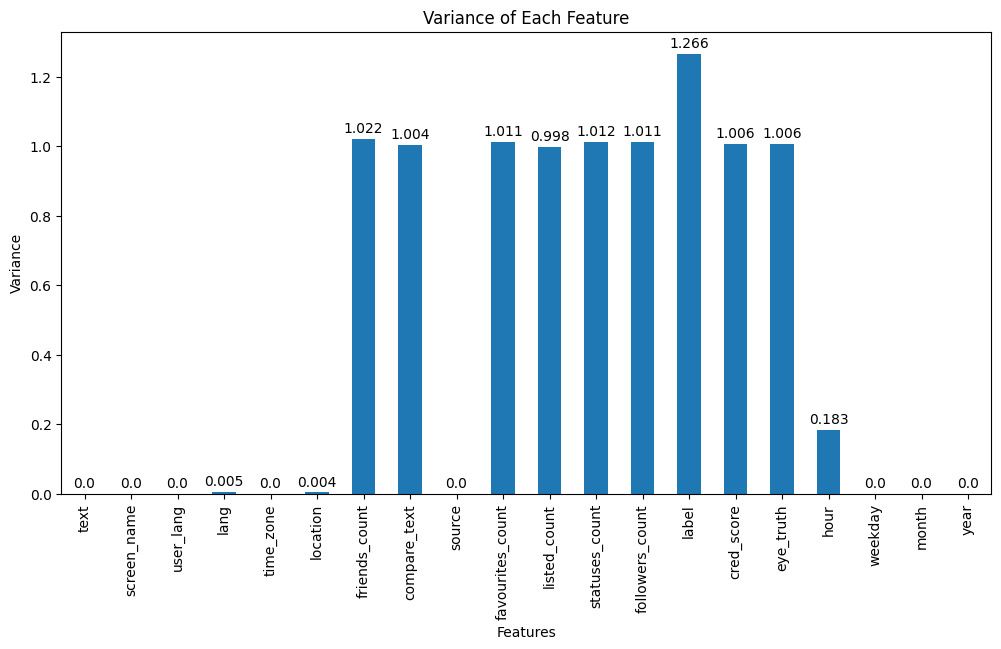

In [55]:
X_train_V, X_test_V, y_train_V, y_test_V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

Dropping Features with variance below 0.8

In [56]:
sel_X_train = X_train_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
sel_X_test = X_test_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)
f1_score = round(f1_score(y_test, preds, average='weighted'), 3)
probs = gbc.predict_proba(X_test)[:, 1]  
auc_score = round(roc_auc_score(y_test, probs), 3)

print(f"F1 Score: {f1_score}")
print(f"AUC Score: {auc_score}")

F1 Score: 0.947
AUC Score: 0.649


SelectKbest feature selection (filter)

In [59]:
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def evaluate_kbest(k, X_train_V1, y_train_V1, X_test_V1, y_test_V1):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_V1, y_train_V1)

    selected_X_train = selector.transform(X_train_V1)
    selected_X_test = selector.transform(X_test_V1)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(selected_X_train, y_train_V1)
    
    kbest_preds = gbc.predict(selected_X_test)
    kbest_probs = gbc.predict_proba(selected_X_test)[:, 1] 

    f1_score_kbest = round(f1_score(y_test_V1, kbest_preds, average='weighted'), 3)
    auc_score_kbest = round(roc_auc_score(y_test_V1, kbest_probs), 3)

    return f1_score_kbest, auc_score_kbest, k


results = Parallel(n_jobs=-1)(delayed(evaluate_kbest)(k, X_train_V1, y_train_V1, X_test_V1, y_test_V1) for k in range(1, 21))

f1_score_list, auc_score_list, feature_counts = zip(*results)

selected_features_dict = {}
for k in range(1, 21):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_V1, y_train_V1)
    selected_features_mask = selector.get_support()
    selected_features_dict[k] = list(X_train_V1.columns[selected_features_mask])

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947)
AUC Scores: (np.float64(0.5), np.float64(0.5), np.float64(0.506), np.float64(0.506), np.float64(0.5), np.float64(0.516), np.float64(0.63), np.float64(0.632), np.float64(0.643), np.float64(0.645), np.float64(0.643), np.float64(0.641), np.float64(0.643), np.float64(0.643), np.float64(0.642), np.float64(0.641), np.float64(0.642), np.float64(0.649), np.float64(0.647), np.float64(0.649))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


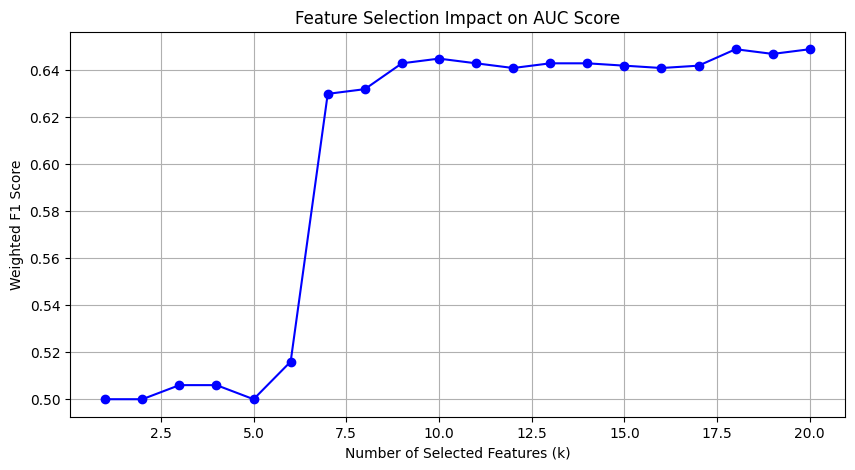

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, auc_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("Feature Selection Impact on AUC Score")
plt.grid(True)
plt.show()

Recursive Feature Elimination (Wrapper)

In [61]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

gbc = GradientBoostingClassifier(random_state=42)

def evaluate_rfe(k, X_train_V2, y_train_V2, X_test_V2, y_test_V2):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_V2, y_train_V2)

    sel_X_train_V2 = RFE_selector.transform(X_train_V2)
    sel_X_test_V2 = RFE_selector.transform(X_test_V2)

    selected_features = np.where(RFE_selector.support_)[0]
    
    gbc.fit(sel_X_train_V2, y_train_V2)
    RFE_preds = gbc.predict(sel_X_test_V2)
    f1_score_RFE = round(f1_score(y_test_V2, RFE_preds, average="weighted"), 3)


    RFE_probs = gbc.predict_proba(sel_X_test_V2)[:, 1]  
    auc_score_RFE = round(roc_auc_score(y_test_V2, RFE_probs), 3)

    return f1_score_RFE, auc_score_RFE, k, selected_features

results = Parallel(n_jobs=-1)(delayed(evaluate_rfe)(k, X_train_V2, y_train_V2, X_test_V2, y_test_V2) for k in range(1, 21))

f1_score_list, auc_score_list, feature_counts, selected_features_list = zip(*results)

selected_features_dict = {}
for k, features in zip(range(1, 21), selected_features_list):
    selected_features_dict[k] = features

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947, 0.947)
AUC Scores: (np.float64(0.516), np.float64(0.632), np.float64(0.635), np.float64(0.641), np.float64(0.64), np.float64(0.643), np.float64(0.642), np.float64(0.642), np.float64(0.642), np.float64(0.645), np.float64(0.647), np.float64(0.648), np.float64(0.649), np.float64(0.648), np.float64(0.647), np.float64(0.647), np.float64(0.647), np.float64(0.647), np.float64(0.647), np.float64(0.649))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


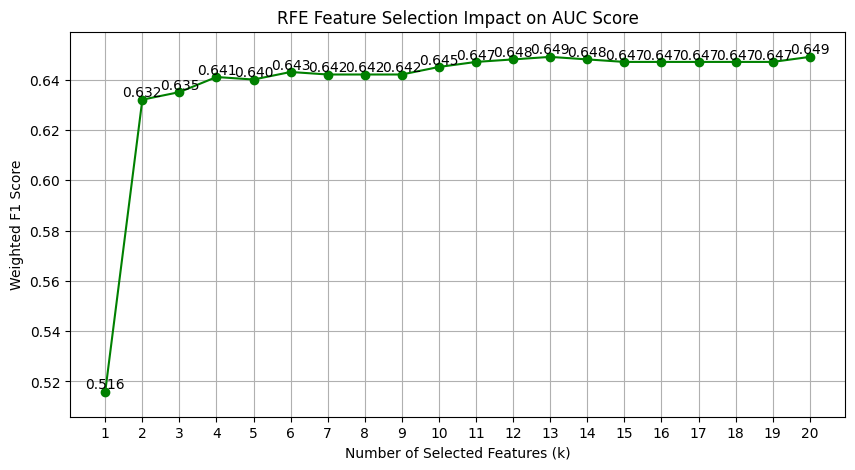

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), auc_score_list, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("RFE Feature Selection Impact on AUC Score")
plt.xticks(range(1, 21))
plt.ylim(min(auc_score_list) - 0.01, max(auc_score_list) + 0.01)
plt.grid(True)

for i, score in enumerate(auc_score_list, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()
